## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Segmentation using Pretrained U-Net
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [ ]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get images
!unzip /content/drive/MyDrive/Image_Segmentation/images_BloodCellSegmentation.zip
y

Archive:  /content/drive/MyDrive/Image_Segmentation/images_BloodCellSegmentation.zip
replace images_BloodCellSegmentation/001.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# get targets
!unzip /content/drive/MyDrive/Image_Segmentation/targets_BloodCellSegmentation.zip

Archive:  /content/drive/MyDrive/Image_Segmentation/targets_BloodCellSegmentation.zip
  inflating: targets_BloodCellSegmentation/001.png  
  inflating: targets_BloodCellSegmentation/002.png  
  inflating: targets_BloodCellSegmentation/003.png  
  inflating: targets_BloodCellSegmentation/004.png  
  inflating: targets_BloodCellSegmentation/005.png  
  inflating: targets_BloodCellSegmentation/006.png  
  inflating: targets_BloodCellSegmentation/007.png  
  inflating: targets_BloodCellSegmentation/008.png  
  inflating: targets_BloodCellSegmentation/009.png  
  inflating: targets_BloodCellSegmentation/010.png  
 extracting: targets_BloodCellSegmentation/011.png  
 extracting: targets_BloodCellSegmentation/012.png  
  inflating: targets_BloodCellSegmentation/013.png  
  inflating: targets_BloodCellSegmentation/014.png  
  inflating: targets_BloodCellSegmentation/015.png  
  inflating: targets_BloodCellSegmentation/016.png  
 extracting: targets_BloodCellSegmentation/017.png  
 extracting: 

In [ ]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.hub import load

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [ ]:
# define filepaths
images_dir = '/content/images_BloodCellSegmentation'
targets_dir = '/content/targets_BloodCellSegmentation'

## Code with comment

In [ ]:
# Define custom dataset class
class BloodCellSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        # Constructor method to initialize the dataset
        # 'images_dir' is the directory containing input images
        # 'masks_dir' is the directory containing segmentation masks corresponding to images

        # Get all image names from the directory
        self.image_names = os.listdir(images_dir)

        # Initialize lists to store full paths for images and masks
        self.images_paths = []
        self.masks_paths = []

        # Iterate over each image name
        for image_name in self.image_names:
            # Construct the full path for the image
            self.images_paths.append(os.path.join(images_dir, image_name))
            # Construct the full path for the corresponding mask
            # Assumes masks have the same name as images but with a .png extension
            self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png')) #image_01.png

    def __getitem__(self, idx):
        # Method to retrieve an image-mask pair by index 'idx'

        # Load the image and corresponding mask using their paths
        image = Image.open(self.images_paths[idx])
        mask = Image.open(self.masks_paths[idx])

        # Convert the mask into a NumPy array for preprocessing
        mask = np.array(mask)
        # Create a binary mask where pixel values of 128 or 255 are considered foreground (True)
        mask = ((mask == 128) | (mask == 255))
        # Convert the binary mask back into a PIL image for consistency
        mask = Image.fromarray(mask)

        # Apply transformations: resizing to 224x224 and converting to PyTorch tensors
        transform = Compose([
            Resize(224),  # Resize both the image and mask to 224x224
            ToTensor()    # Convert PIL images to PyTorch tensors
        ])
        # Apply the transformations to the image and mask
        image = transform(image)
        mask = transform(mask)

        # Return the transformed image and mask as a pair
        return image, mask

    def __len__(self):
        # Method to return the total number of samples in the dataset
        # The length is equal to the number of images
        return len(self.image_names)


#### 1.2 Define custom dataset and dataloader

In [ ]:
# define custom dataset class
class BloodCellSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir):

        # get all image names
        self.image_names = os.listdir(images_dir)

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, idx):

        # read data
        image = Image.open(self.images_paths[idx])
        mask = Image.open(self.masks_paths[idx])

        # preprocess mask
        mask = np.array(mask)
        mask = ((mask == 128) | (mask == 255))
        mask = Image.fromarray(mask)

        # apply data augmentation
        transform = Compose([
                    Resize(224),
                    ToTensor()
                    ])

        image = transform(image)
        mask = transform(mask)

        return image, mask

    def __len__(self):
        return len(self.image_names)

## Code with Comment

In [ ]:
# Create an instance of the custom dataset class
dataset = BloodCellSegDataset(images_dir, targets_dir)
# This initializes the `BloodCellSegDataset` class by passing two arguments:
# 'images_dir': The directory containing the input images.
# 'targets_dir': The directory containing the segmentation masks.
# The dataset object now provides access to the preprocessed image-mask pairs.

# Create a DataLoader for the dataset
data_loader = DataLoader(
    dataset,         # The dataset instance to be loaded.
    batch_size=8,    # Number of samples (image-mask pairs) per batch during training or inference.
    num_workers=4,   # Number of subprocesses to use for data loading to improve efficiency.
    shuffle=True     # Shuffle the dataset at every epoch to introduce randomness in the training process.
)
# The DataLoader object helps in loading the dataset in batches, performing efficient data loading,
# and optionally shuffling the data. It is essential for training machine learning models in PyTorch.


In [ ]:
# create instance of custom dataset
dataset = BloodCellSegDataset(images_dir, targets_dir)

# create dataloader
data_loader = DataLoader(
    dataset,
    batch_size=8,
    num_workers=4,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### 1.3 Data Exploration

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in data_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# get shapes of batches
batch_x.shape, batch_y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 1, 224, 224]))

In [ ]:
batch_y[1].shape

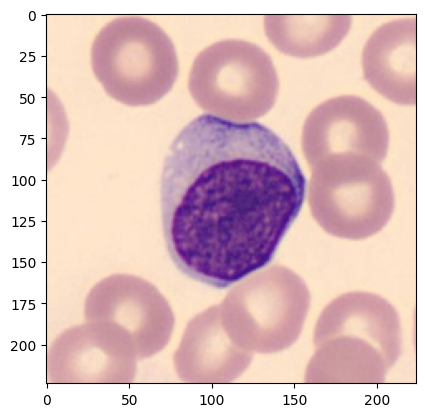

In [ ]:
# print image
plt.imshow(np.transpose(batch_x[1], (1, 2, 0)))

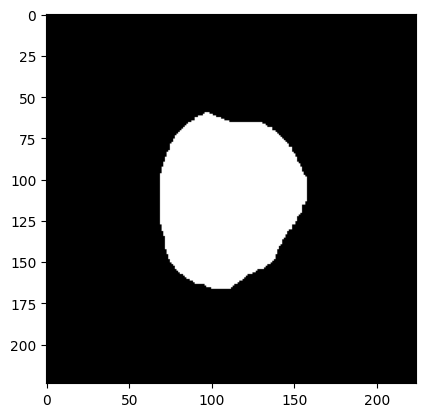

In [ ]:
# print mask
plt.imshow(batch_y[1].squeeze(), cmap='gray')

### 2. Image Segmentation using Pretrained U-Net

#### 2.1 Define model architecture

In [ ]:
# define model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
# print model architecture
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# check forward pass
model.forward

In [ ]:
# check model on one image
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

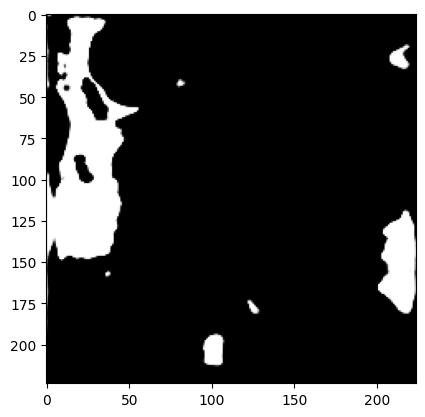

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(50):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs, batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.05946448201743456 
Training loss for epoch 2 is 0.052312439594131246 
Training loss for epoch 3 is 0.04327811042849834 
Training loss for epoch 4 is 0.04380355259546867 
Training loss for epoch 5 is 0.045191600918769836 
Training loss for epoch 6 is 0.06588083792191285 
Training loss for epoch 7 is 0.07588951748151046 
Training loss for epoch 8 is 0.05024194043989365 
Training loss for epoch 9 is 0.05140094272792339 
Training loss for epoch 10 is 0.04135091502505999 
Training loss for epoch 11 is 0.04131709196819709 
Training loss for epoch 12 is 0.03913130553869101 
Training loss for epoch 13 is 0.03423940877501781 
Training loss for epoch 14 is 0.029980954069357652 
Training loss for epoch 15 is 0.029505826676121123 
Training loss for epoch 16 is 0.027300692235048 
Training loss for epoch 17 is 0.02723113253999215 
Training loss for epoch 18 is 0.03001468270443953 
Training loss for epoch 19 is 0.03252717752296191 
Training loss for epoch 20 is 0.051444

#### 2.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/images_BloodCellSegmentation/002.bmp')
gt_mask = Image.open('/content/targets_BloodCellSegmentation/002.png')

# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = ((gt_mask == 128) | (gt_mask == 255))
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize(224),
            ToTensor()
            ])

image = transform(image)

gt_mask = transform(gt_mask)

In [ ]:
# get prediction
model.eval()
output = model(image.unsqueeze(dim=0).to('cuda')).cpu().detach().numpy()

In [ ]:
# print shape
output.shape

(1, 1, 224, 224)

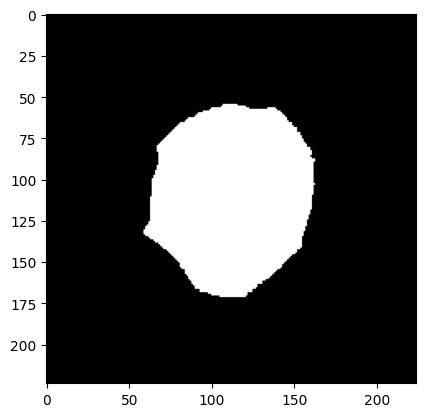

In [ ]:
# plot ground truth mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

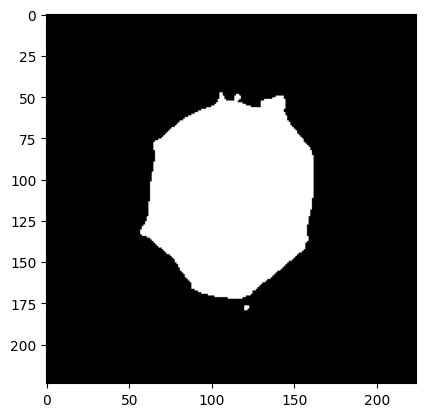

In [ ]:
# plot predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for WBC
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9473574481392683